## Importing Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import autokeras as ak

from Model_Parent import *
from Model_Parent_2 import *

2022-04-02 18:40:37.574308: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-02 18:40:37.574382: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Importing Data

In [2]:
df = pd.read_csv("../cleaned_data/CCPP.csv", index_col=0)

df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


## Checking Data

<AxesSubplot:>

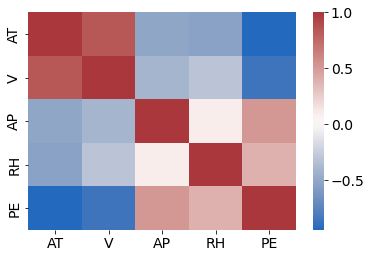

In [3]:
# Check to make sure that no columns have perfect colinearity
corr_mat = df.corr(method='pearson')
sns.heatmap(corr_mat, cmap='vlag')

## Scaling Data

In [4]:
# Storing old columns names
df_col_names = list(df.columns)

# Scaling data by min and max in the range of 0 to 1
scaler = MinMaxScaler(feature_range = [0, 1])
tmp = scaler.fit_transform(df)

# Converting scaled values back into dataframe
df = pd.DataFrame(tmp, columns=df_col_names)

df

,AT,V,AP,RH,PE
0,0.372521,0.291815,0.771591,0.638204,0.569536
1,0.662040,0.669039,0.671863,0.449330,0.319338
2,0.093484,0.249822,0.476862,0.892493,0.904636
3,0.539660,0.568683,0.429349,0.684718,0.347285
4,0.255241,0.216014,0.404355,0.952547,0.710464
...,...,...,...,...,...
9563,0.420397,0.432918,0.522643,0.877212,0.526755
9564,0.322380,0.245907,0.761693,0.552547,0.653775
9565,0.835977,0.871352,0.495669,0.146381,0.123311
9566,0.642210,0.784520,0.518931,0.493700,0.205033


## Breaking Data in X and y

In [5]:
X = df.iloc[:,:-1]

In [6]:
y = df.iloc[:,-1]

# Generating Models

In [9]:
# Using AutoKeras output to help us tune our parameters
# Can adjust hyperpameters, activation functions, and layer stucture based on our findings

auto_tune = ak.StructuredDataRegressor(max_trials=10, 
                                       overwrite=True,
                                       loss='mean_squared_error',
                                       output_dim=1,
                                       project_name='auto_keras'
                                       )

X_train, X_test, y_train, y_test = train_test_split(X, y)

auto_tune.fit(X_train, y_train, validation_split = 0.15, epochs = 10)
y_hat = auto_tune.predict(X_test)
print(auto_tune.evaluate(X_test, y_test))

auto_tune_mod = auto_tune.export_model()
print(auto_tune_mod.summary())


Trial 10 Complete [00h 00m 06s]
val_loss: 0.0034147887490689754

Best val_loss So Far: 0.003198010614141822
Total elapsed time: 00h 01m 21s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
225/225 [==============================] - 1s 1ms/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 2/10
225/225 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 3/10
225/225 [==============================] - 0s 1ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 4/10
225/225 [==============================] - 0s 1ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 5/10
225/225 [==============================] - 0s 1ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 6/10
225/225 [==============================] - 0s 1ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 7/10
225/225 [==============================] - 0s 1ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 8/10
225/225 [==============================] 

2022-04-02 18:18:55.931924: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./auto_keras/best_model/assets
75/75 [==============================] - 0s 1ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[0.0029594418592751026, 0.0029594418592751026]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 4)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                160       
                                                 

In [7]:
# Defining number of folds in cross validation (kfolds method)
cv_folds = 5

# Defining number of epochs
epo = 50

# Defining batch size
bs = 32

# opt is the optimazation function of choice
opt = 'adam'

# loss_ is the loss funciton of choice
loss_ = 'mean_squared_error'

## 2 Layer Neural Networks

### Sigmoid Activation Function

In [11]:
# nur_list is a list of number of neurons for each layer.
# In this case the first 2 values in the list are neurons of first 2 layers.
# The first value corresponds to the input layer
# The last value corresponds to the output layer
nur_list = [X.shape[1], 1]

# a_func is the activation function of choice
a_func = 'sigmoid'

In [12]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
240/240 [==============================] - 1s 1ms/step - loss: 0.0518
Epoch 2/50
240/240 [==============================] - 0s 1ms/step - loss: 0.0453
Epoch 3/50
240/240 [==============================] - 1s 4ms/step - loss: 0.0381
Epoch 4/50
240/240 [==============================] - 0s 2ms/step - loss: 0.0300
Epoch 5/50
240/240 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 6/50
240/240 [==============================]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 4)                 20        
                                                                 
 dense_13 (Dense)            (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________

FORWARD SELECTION REPORT:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Sat, 02 Apr 2022   Prob (F-statistic):               0.00
Time:                        18

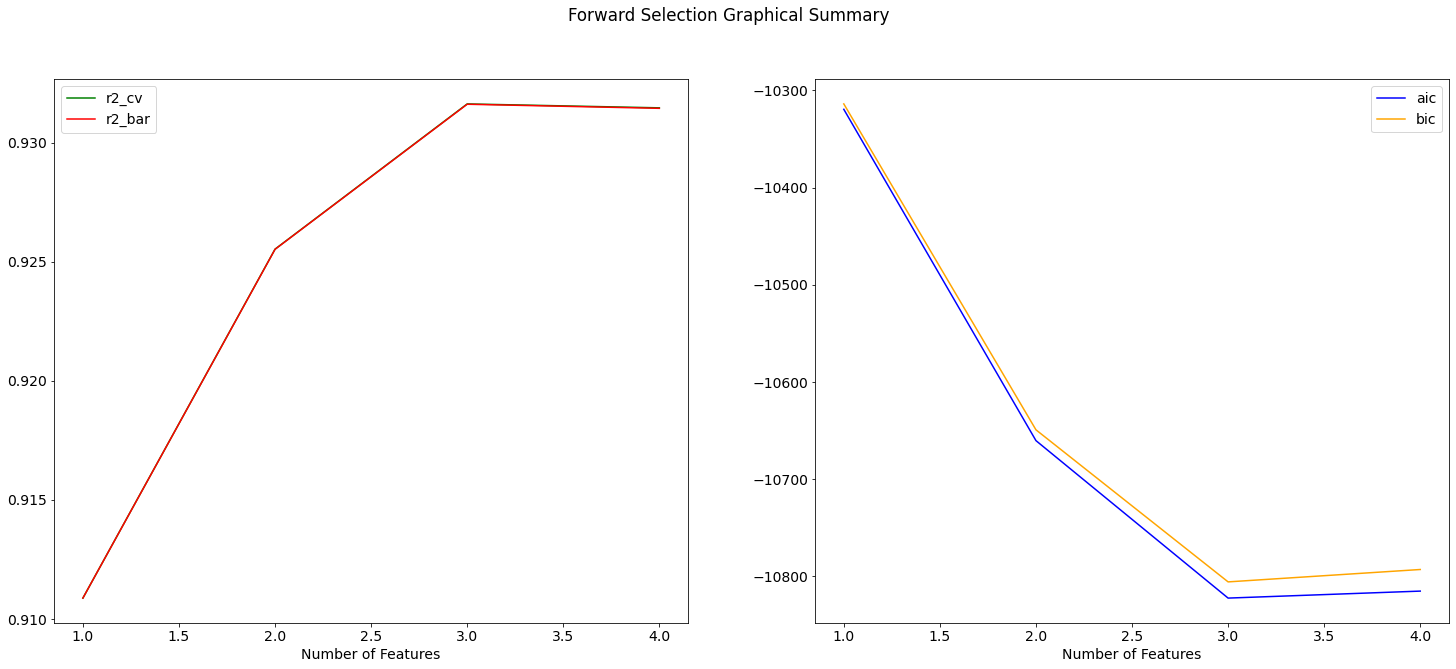

In [13]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

### Tanh Activation Function

In [8]:
# nur_list is a list of number of neurons for each layer.
# In this case the first 2 values in the list are neurons of first 2 layers.
# The first value corresponds to the input layer
# The last value corresponds to the output layer
nur_list = [X.shape[1], 1]

# a_func is the activation function of choice
a_func = 'tanh'

In [9]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

2022-04-02 18:41:09.731158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-02 18:41:09.731280: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-02 18:41:09.731329: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
2022-04-02 18:41:09.732669: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
240/240 [==============================] - 1s 955us/step - loss: 0.0497
Epoch 2/50
240/240 [==============================] - 0s 893us/step - loss: 0.0148
Epoch 3/50
240/240 [==============================] - 0s 986us/step - loss: 0.0086
Epoch 4/50
240/240 [==============================] - 0s 940us/step - loss: 0.0076
Epoch 5/50
240/240 [==============================] - 0s 959us/step - loss: 0.0070
Epoch 6/50
240/240 [=====================

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 4)                 20        
                                                                 
 dense_11 (Dense)            (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________

FORWARD SELECTION REPORT:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Sat, 02 Apr 2022   Prob (F-statistic):               0.00
Time:                        18

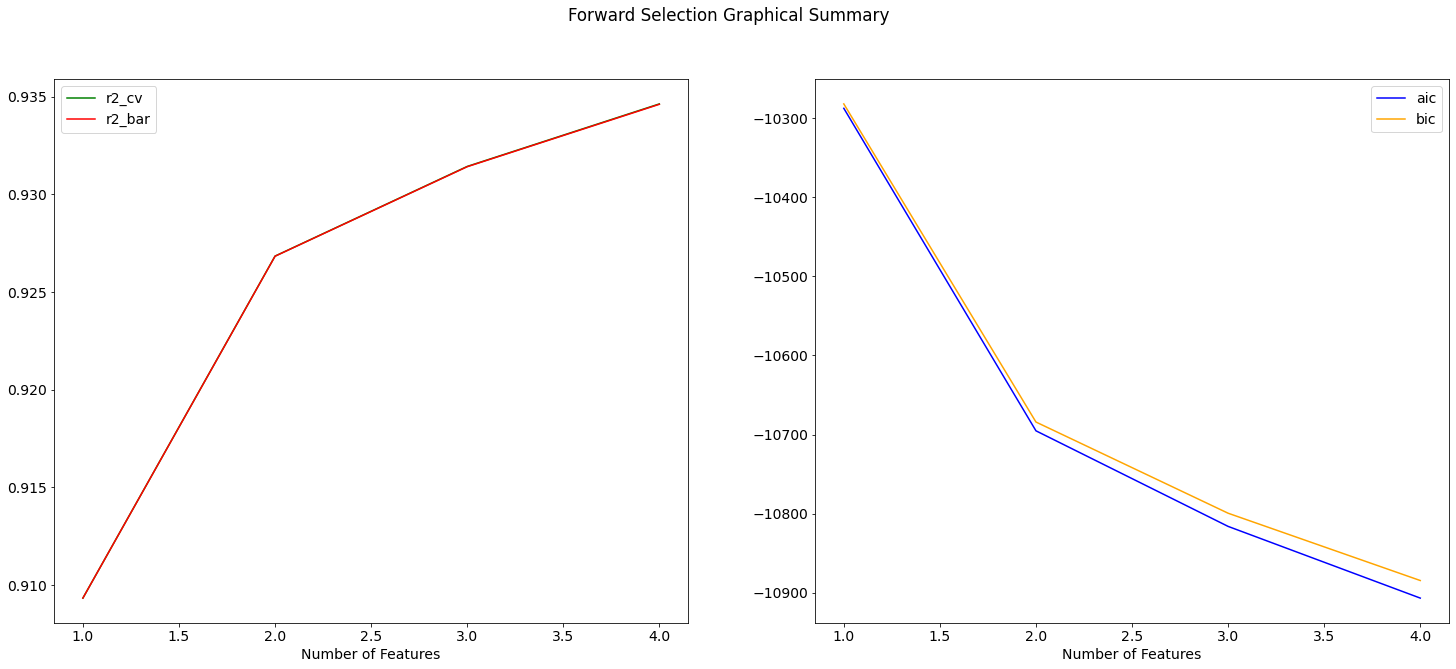

In [10]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

### ReLU Activation Function

In [11]:
# nur_list is a list of number of neurons for each layer.
# In this case the first 2 values in the list are neurons of first 2 layers.
# The first value corresponds to the input layer
# The last value corresponds to the output layer
nur_list = [X.shape[1], 1]

# a_func is the activation function of choice
a_func = 'relu'

In [12]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 4)                 20        
                                                                 
 dense_53 (Dense)            (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
240/240 [==============================] - 0s 828us/step - loss: 0.1724
Epoch 2/50
240/240 [==============================] - 0s 798us/step - loss: 0.0252
Epoch 3/50
240/240 [==============================] - 0s 939us/step - loss: 0.0113
Epoch 4/50
240/240 [==============================] - 0s 835us/step - loss: 0.0065
Epoch 5/50
240/240 [==============================] - 0s 913us/step - loss: 0.0048
Epoch 6/50
240/240 [==================

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 4)                 20        
                                                                 
 dense_63 (Dense)            (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________

FORWARD SELECTION REPORT:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Sat, 02 Apr 2022   Prob (F-statistic):               0.00
Time:                        1

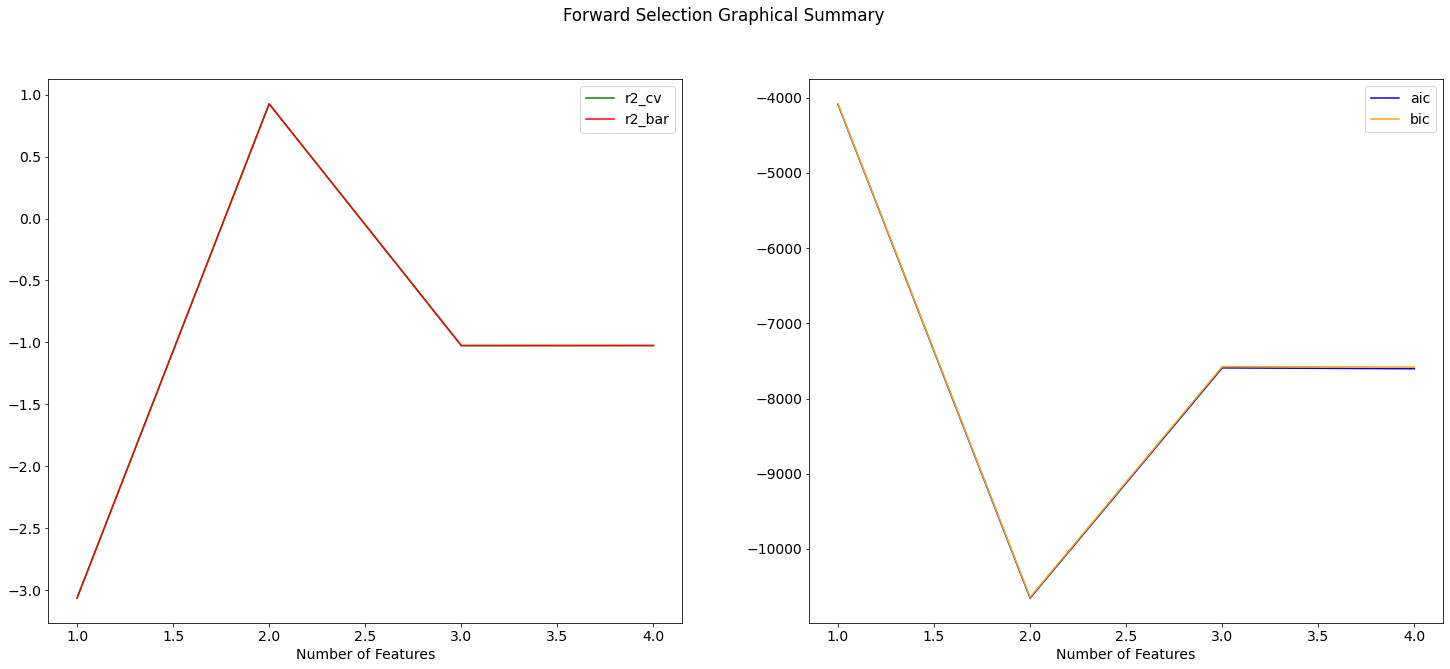

In [13]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

## 3 Layer Neural Networks

### Sigmoid Activation Function

In [14]:
# nur_list is a list of number of neurons for each layer.
# In this case, the first 3 values in the list are neurons of first 3 layers.
# The first value corresponds to the input layer
# The middle value is the hidden layers
# The last value corresponds to the output layer
nur_list = [X.shape[1], 2 * X.shape[1] + 1, 1]

# a_func is the activation function of choice
a_func = 'sigmoid'

In [15]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 4)                 20        
                                                                 
 dense_105 (Dense)           (None, 9)                 45        
                                                                 
 dense_106 (Dense)           (None, 1)                 10        
                                                                 
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
240/240 [==============================] - 1s 957us/step - loss: 0.0561
Epoch 2/50
240/240 [==============================] - 0s 1ms/step - loss: 0.0474
Epoch 3/50
240/240 [==============================] - 0s 1ms/step - loss: 0.0426
Epoch 4/50
240/240 [==============================] - 0s 1ms/step - loss: 0.

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_119 (Dense)           (None, 4)                 20        
                                                                 
 dense_120 (Dense)           (None, 9)                 45        
                                                                 
 dense_121 (Dense)           (None, 1)                 10        
                                                                 
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________

FORWARD SELECTION REPORT:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:    

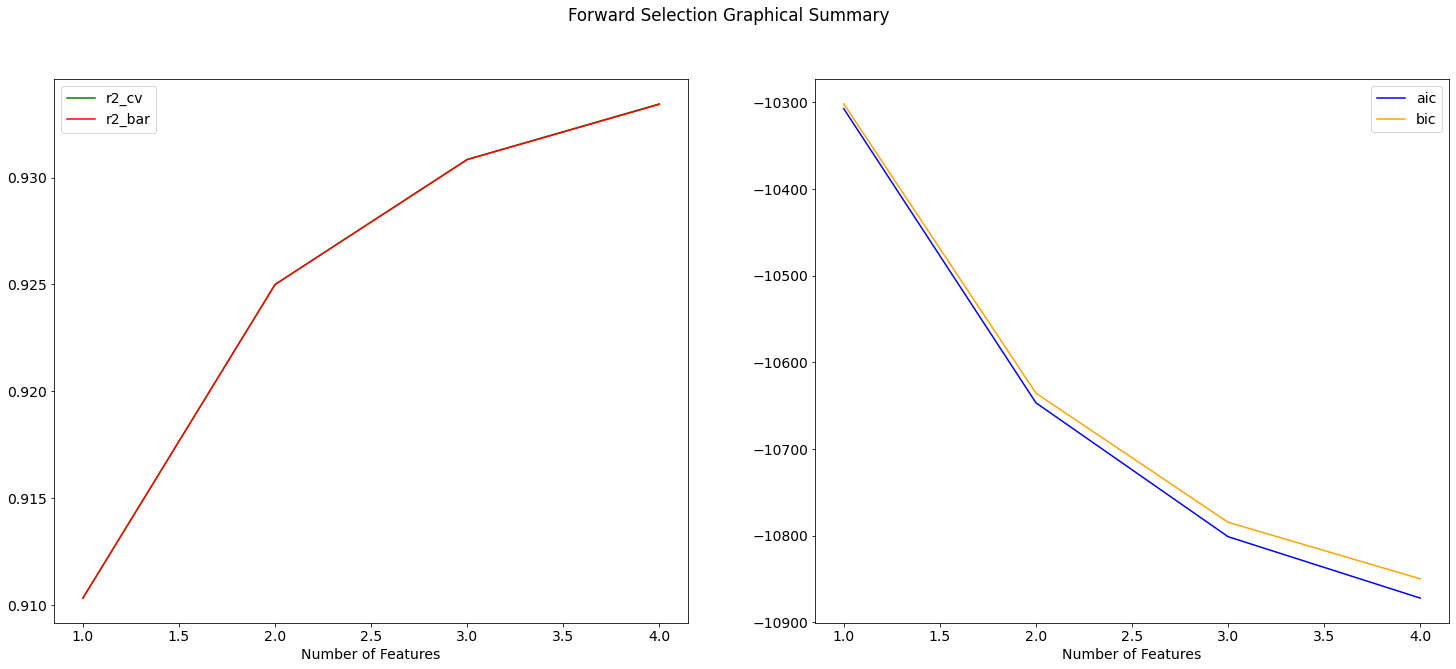

In [16]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

### Tanh Activation Function

In [17]:
# nur_list is a list of number of neurons for each layer.
# In this case, the first 3 values in the list are neurons of first 3 layers.
# The first value corresponds to the input layer
# The middle value is the hidden layers
# The last value corresponds to the output layer
nur_list = [X.shape[1], 2 * X.shape[1] + 1, 1]

# a_func is the activation function of choice
a_func = 'tanh'

In [18]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_182 (Dense)           (None, 4)                 20        
                                                                 
 dense_183 (Dense)           (None, 9)                 45        
                                                                 
 dense_184 (Dense)           (None, 1)                 10        
                                                                 
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
240/240 [==============================] - 1s 1ms/step - loss: 0.0326
Epoch 2/50
240/240 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 3/50
240/240 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 4/50
240/240 [==============================] - 0s 1ms/step - loss: 0.00

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_197 (Dense)           (None, 4)                 20        
                                                                 
 dense_198 (Dense)           (None, 9)                 45        
                                                                 
 dense_199 (Dense)           (None, 1)                 10        
                                                                 
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________

FORWARD SELECTION REPORT:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:    

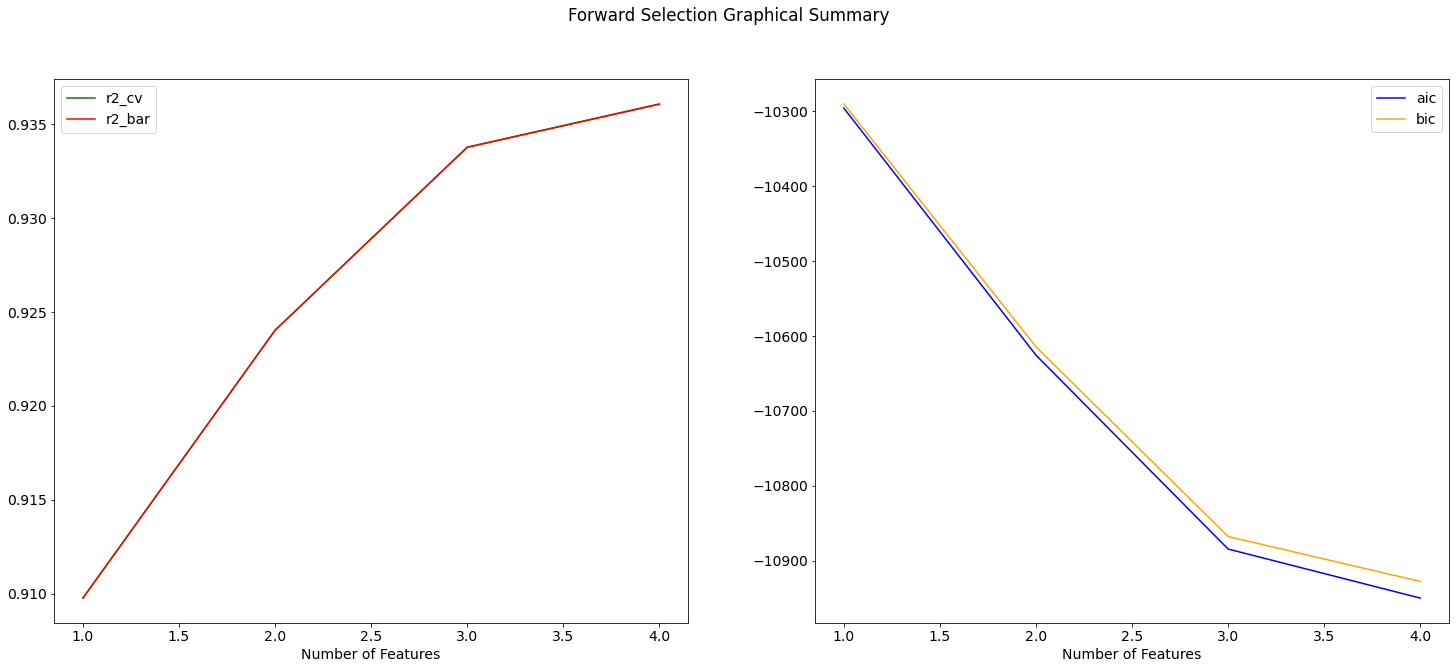

In [19]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

### ReLU Activation Function

In [20]:
# nur_list is a list of number of neurons for each layer.
# In this case, the first 3 values in the list are neurons of first 3 layers.
# The first value corresponds to the input layer
# The middle value is the hidden layers
# The last value corresponds to the output layer
nur_list = [X.shape[1], 2 * X.shape[1] + 1, 1]

# a_func is the activation function of choice
a_func = 'relu'

In [21]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_260 (Dense)           (None, 4)                 20        
                                                                 
 dense_261 (Dense)           (None, 9)                 45        
                                                                 
 dense_262 (Dense)           (None, 1)                 10        
                                                                 
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
240/240 [==============================] - 1s 974us/step - loss: 0.0602
Epoch 2/50
240/240 [==============================] - 0s 892us/step - loss: 0.0366
Epoch 3/50
240/240 [==============================] - 0s 821us/step - loss: 0.0236
Epoch 4/50
240/240 [==============================] - 0s 869us/step - l

Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_275 (Dense)           (None, 4)                 20        
                                                                 
 dense_276 (Dense)           (None, 9)                 45        
                                                                 
 dense_277 (Dense)           (None, 1)                 10        
                                                                 
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________

FORWARD SELECTION REPORT:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:   

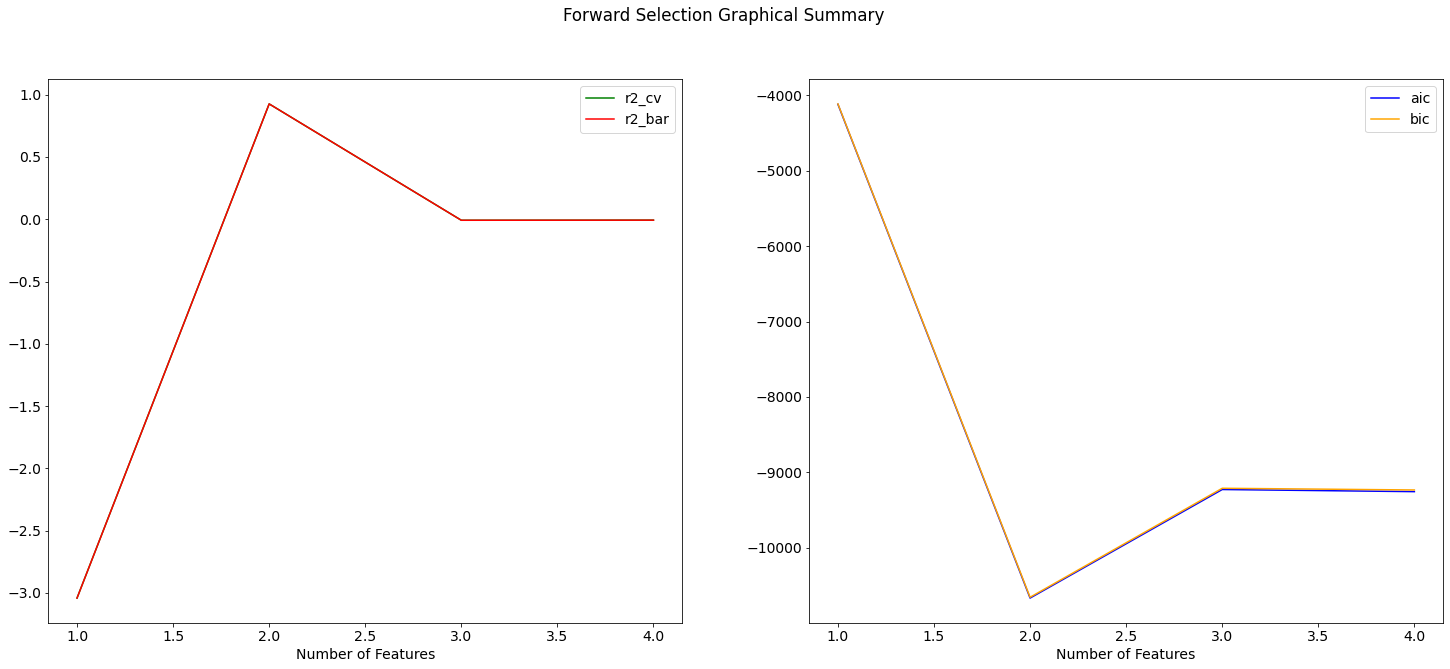

In [22]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

## 4 Layer Neural Networks

### Sigmoid Activation Function

In [23]:
# nur_list is a list of number of neurons for each layer.
# In this case, the first 4 values in the list are neurons of first 4 layers.
# The first value corresponds to the input layer
# The middle values are hidden layers
# The last value corresponds to the output layer
nur_list = [X.shape[1], 2 * X.shape[1] + 1, math.ceil((2 * X.shape[1] + 1)/2), 1]

# a_func is the activation function of choice
a_func = 'sigmoid'

In [24]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_338 (Dense)           (None, 4)                 20        
                                                                 
 dense_339 (Dense)           (None, 9)                 45        
                                                                 
 dense_340 (Dense)           (None, 5)                 50        
                                                                 
 dense_341 (Dense)           (None, 1)                 6         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
240/240 [==============================] - 1s 1ms/step - loss: 0.0973
Epoch 2/50
240/240 [==============================] - 0s 963us/step - loss: 0.0510
Epoch 3/50
240/240 [==

Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_358 (Dense)           (None, 4)                 20        
                                                                 
 dense_359 (Dense)           (None, 9)                 45        
                                                                 
 dense_360 (Dense)           (None, 5)                 50        
                                                                 
 dense_361 (Dense)           (None, 1)                 6         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________

FORWARD SELECTION REPORT:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929


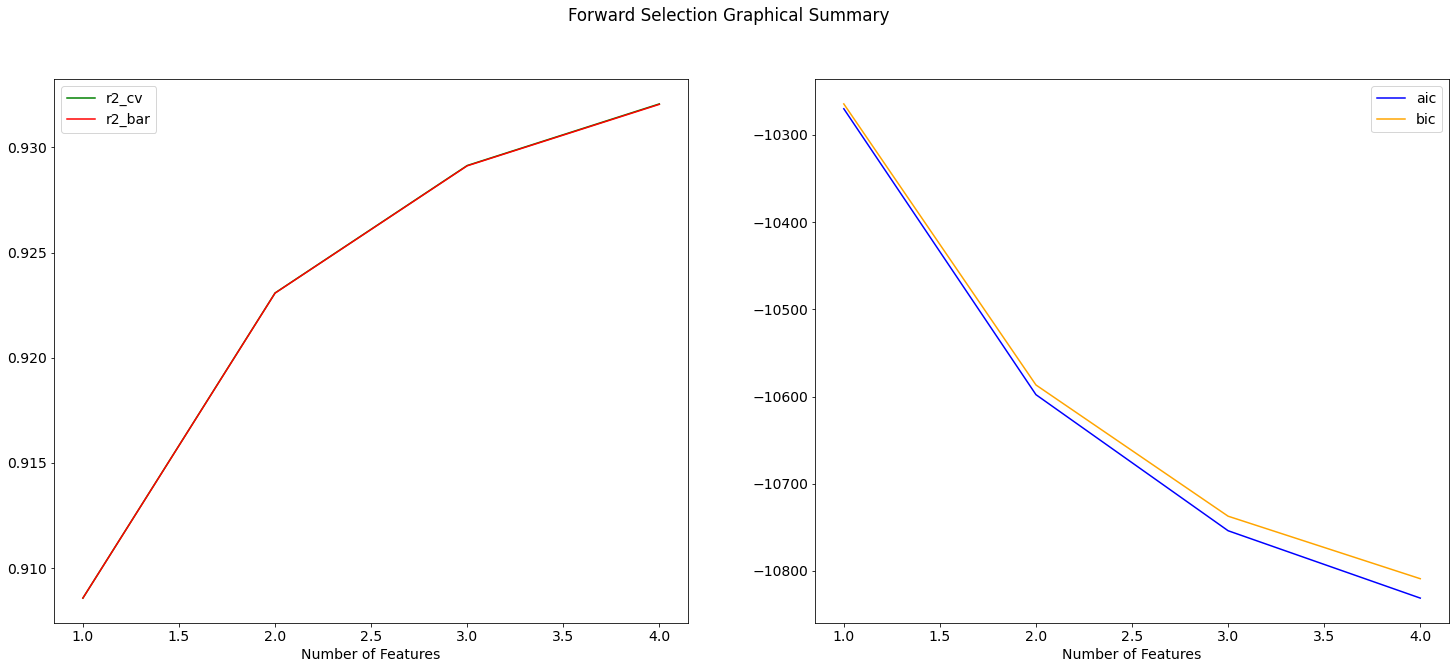

In [25]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

### Tanh Activation Function

In [26]:
# nur_list is a list of number of neurons for each layer.
# In this case, the first 4 values in the list are neurons of first 4 layers.
# The first value corresponds to the input layer
# The middle values are hidden layers
# The last value corresponds to the output layer
nur_list = [X.shape[1], 2 * X.shape[1] + 1, math.ceil((2 * X.shape[1] + 1)/2), 1]

# a_func is the activation function of choice
a_func = 'tanh'

In [27]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

Model: "sequential_156"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_442 (Dense)           (None, 4)                 20        
                                                                 
 dense_443 (Dense)           (None, 9)                 45        
                                                                 
 dense_444 (Dense)           (None, 5)                 50        
                                                                 
 dense_445 (Dense)           (None, 1)                 6         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
240/240 [==============================] - 1s 989us/step - loss: 0.0511
Epoch 2/50
240/240 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 3/50
240/240 [==

Model: "sequential_161"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_462 (Dense)           (None, 4)                 20        
                                                                 
 dense_463 (Dense)           (None, 9)                 45        
                                                                 
 dense_464 (Dense)           (None, 5)                 50        
                                                                 
 dense_465 (Dense)           (None, 1)                 6         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________

FORWARD SELECTION REPORT:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929


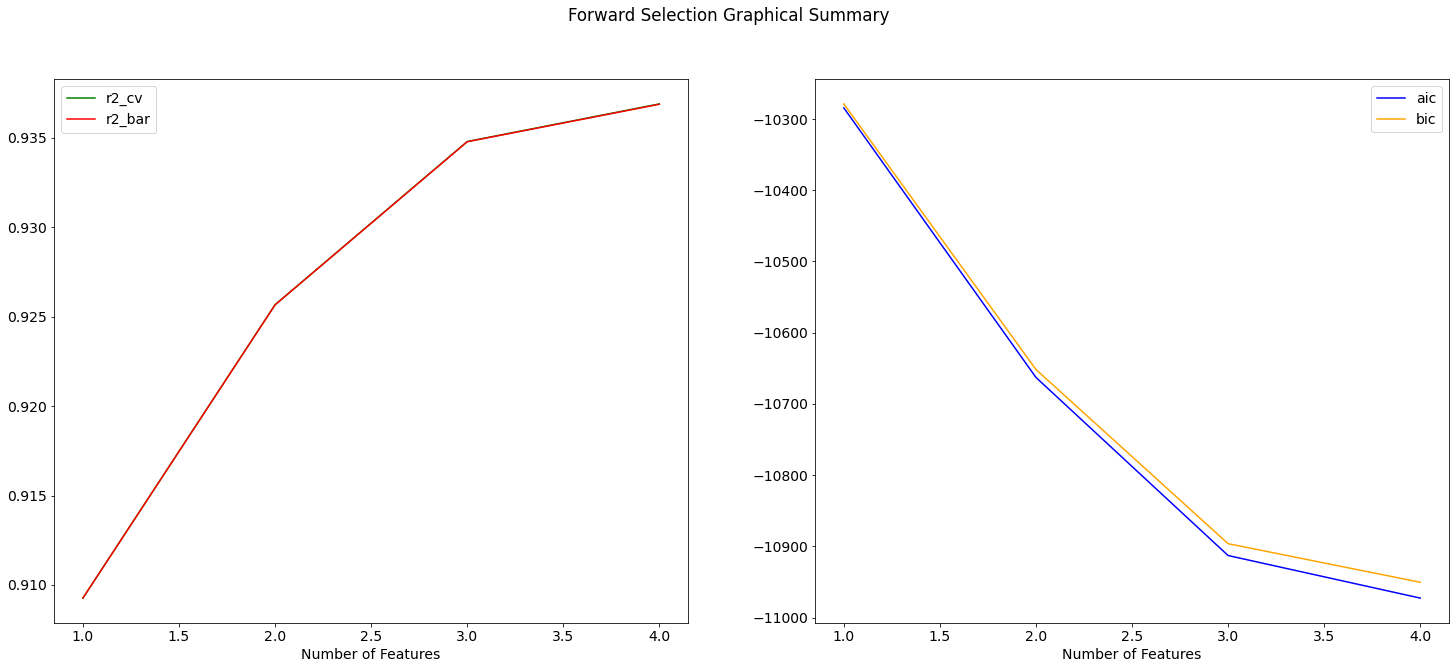

In [28]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

### ReLU Activation Function

In [29]:
# nur_list is a list of number of neurons for each layer.
# In this case, the first 4 values in the list are neurons of first 4 layers.
# The first value corresponds to the input layer
# The middle values are hidden layers
# The last value corresponds to the output layer
nur_list = [X.shape[1], 2 * X.shape[1] + 1, math.ceil((2 * X.shape[1] + 1)/2), 1]

# a_func is the activation function of choice
a_func = 'relu'

In [30]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

Model: "sequential_182"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_546 (Dense)           (None, 4)                 20        
                                                                 
 dense_547 (Dense)           (None, 9)                 45        
                                                                 
 dense_548 (Dense)           (None, 5)                 50        
                                                                 
 dense_549 (Dense)           (None, 1)                 6         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
240/240 [==============================] - 1s 1ms/step - loss: 0.0505
Epoch 2/50
240/240 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 3/50
240/240 [====

Model: "sequential_187"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_566 (Dense)           (None, 4)                 20        
                                                                 
 dense_567 (Dense)           (None, 9)                 45        
                                                                 
 dense_568 (Dense)           (None, 5)                 50        
                                                                 
 dense_569 (Dense)           (None, 1)                 6         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________

FORWARD SELECTION REPORT:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929


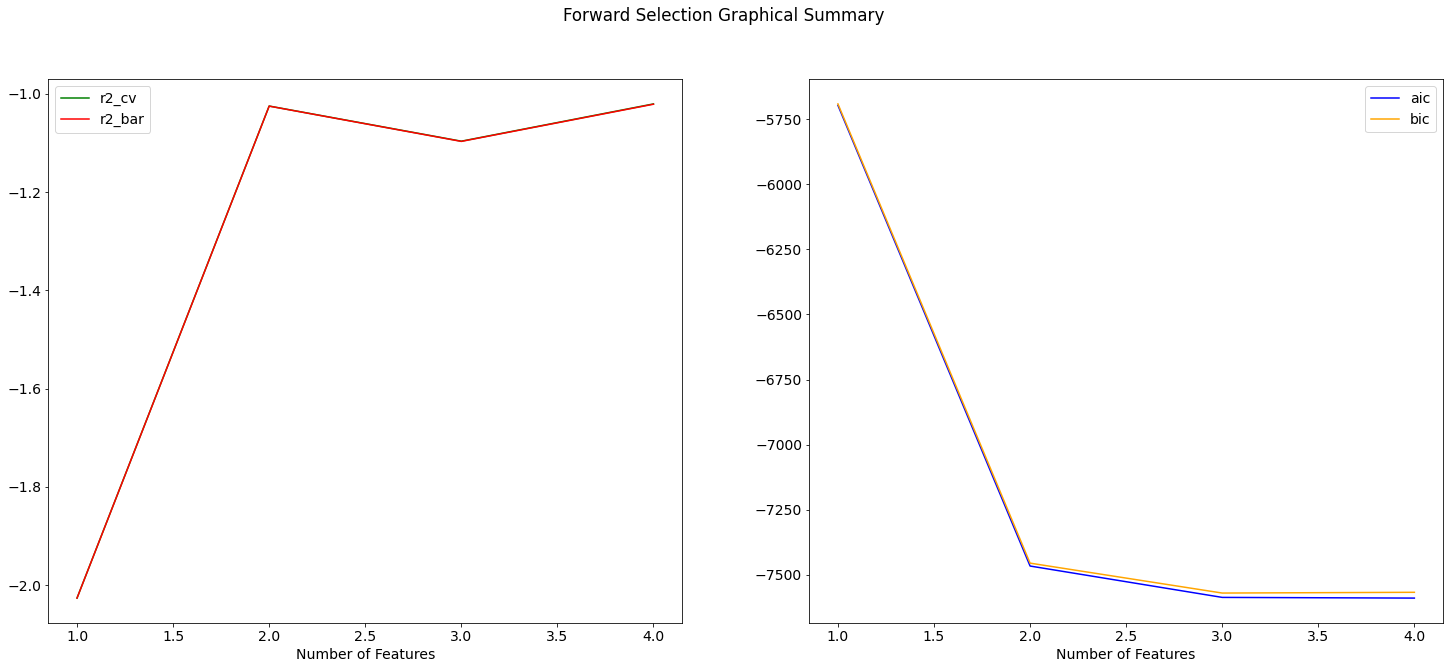

In [31]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)